In [3]:
logo_dir = "logos"

c:\Users\vgale\Desktop\Code\Logo_Recognition_ML\venv\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loaded and preprocessed 1808 images.
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 577ms/step
Extracted features shape: (1808, 1280)


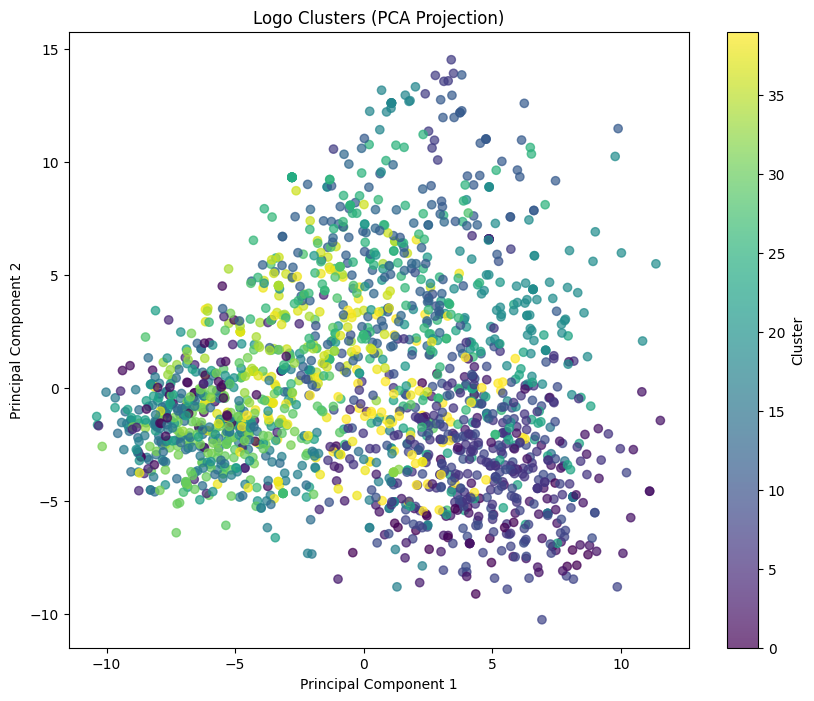

Cluster 17: ['263.net.cn', 'actemium.at', 'actemium.com', 'actemium.sk', 'aiesec.cl', 'ajaxtocco.de', 'amnesty.lu', 'axa-assistance.pl', 'axa.ma', 'bluecardagency.ru', 'boxful.com.tw', 'camesoluciones.com', 'chauffeurstelefoon.nl', 'chubblifefund.com.vn', 'daikin.com.mm', 'daikintexastechnologypark.com', 'dolcevita.ca', 'ebay.com.hk', 'elizabetharden.tw', 'fimacf.africa', 'furuno.fr', 'honda.com.ng', 'hondasemarangcenter.com', 'ilmercatoambacht.nl', 'kiaofbillings.com', 'kiaofmurfreesboro.com', 'kiaofwestchester.com', 'mapfre.com.py', 'menicon.com.au', 'metagenics.co.jp', 'murrelektronik.fi', 'murrelektronik.hu', 'murrelektronik.sk', 'narscosmetics.es', 'nelsonlabsbozeman.com', 'nestle.com.ve', 'pcllawyersfrankston.com.au', 'pearsonactivelearn.com', 'pirtek.nl', 'renaultcancun.com.mx', 'saint-gobain.ru', 'seqens.fi', 'sonepar.co', 'spie-osmo.de', 'sto-ukraine.com', 'synlab.com.gh', 'synlab.hr', 'thebodyshop.lv', 'thebodyshop.si', 'titancontainers.dk', 'toyota-indus.com', 'toyota-innvie

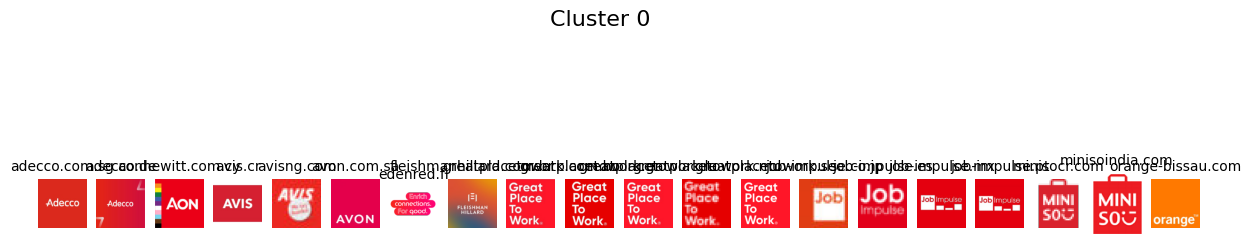

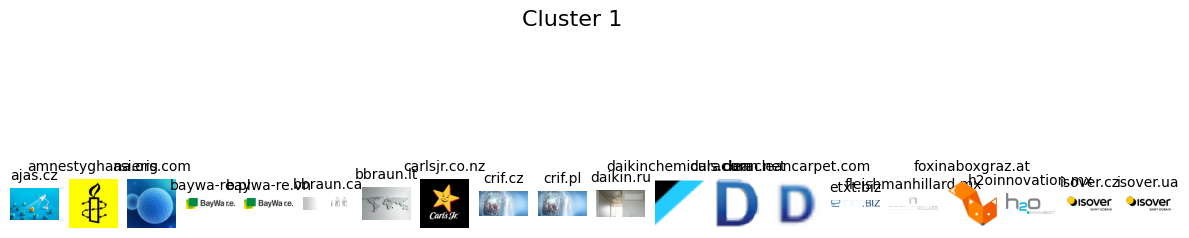

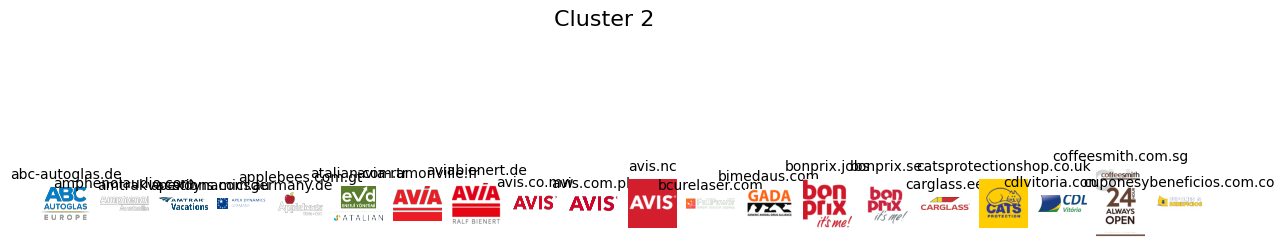

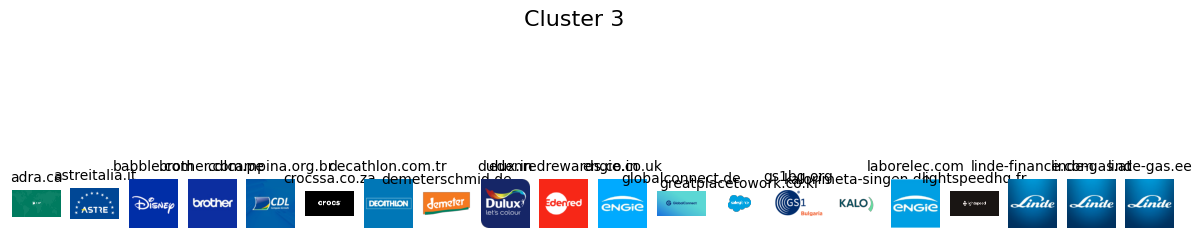

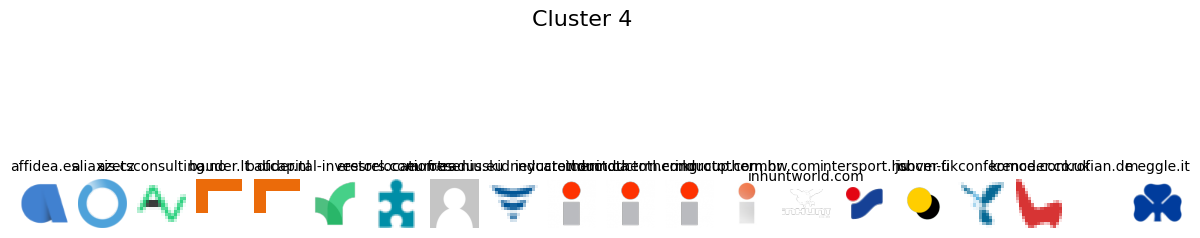

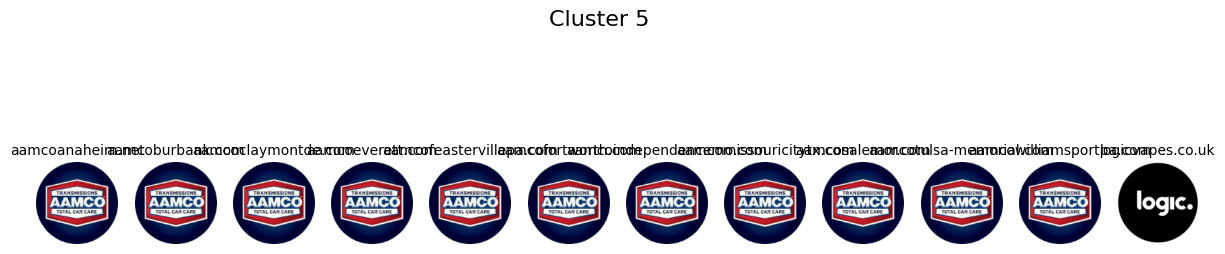

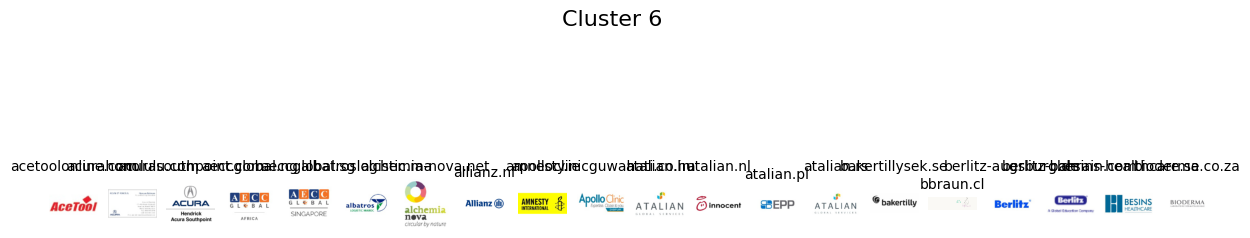

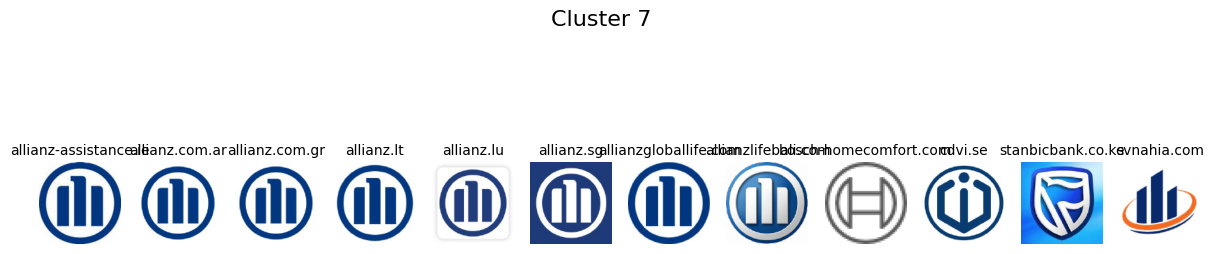

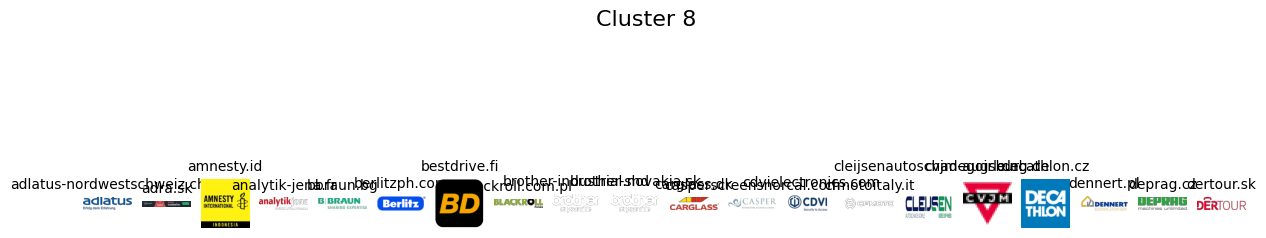

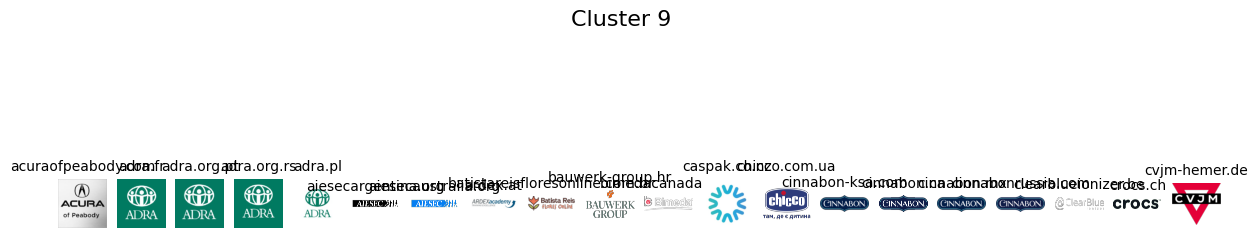

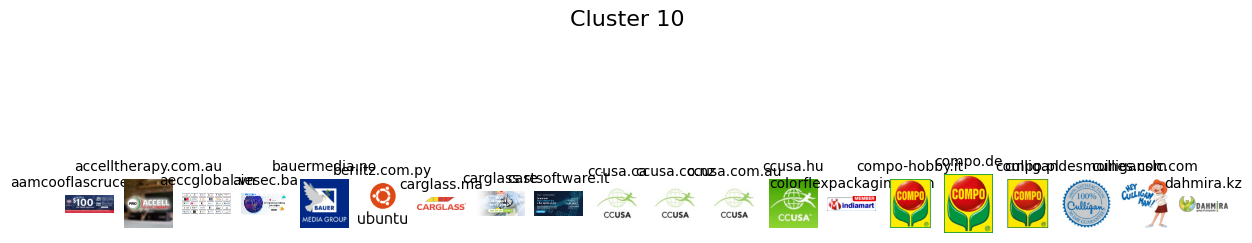

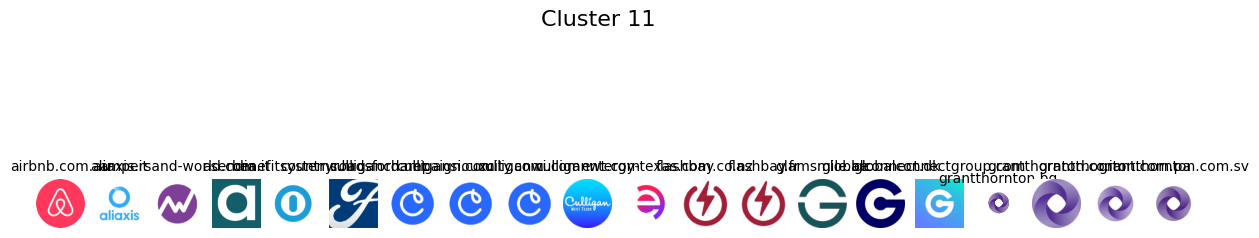

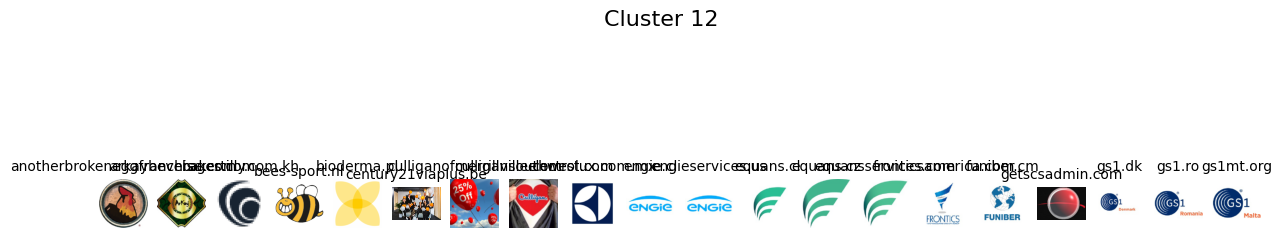

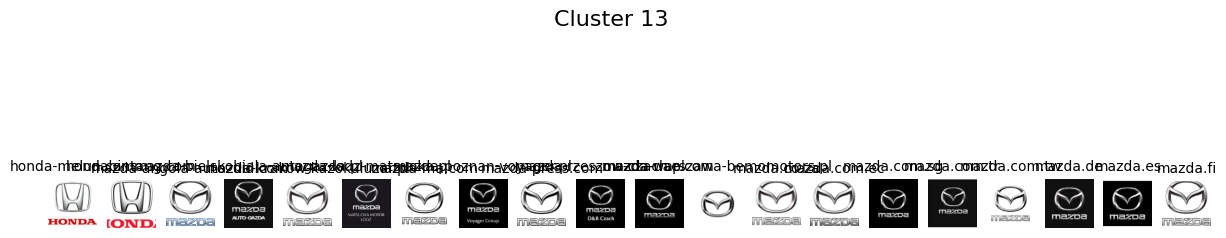

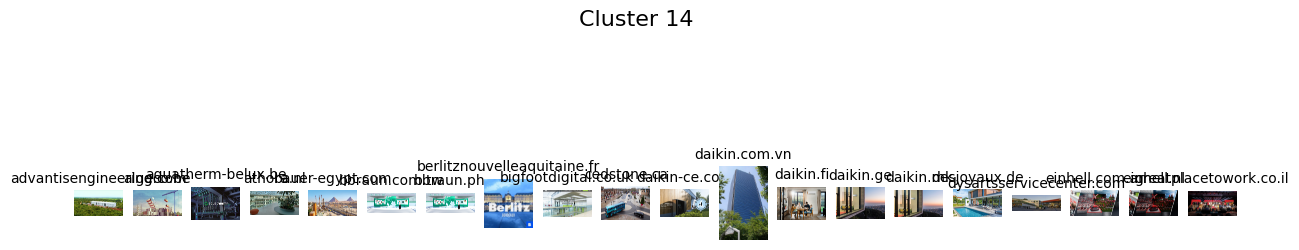

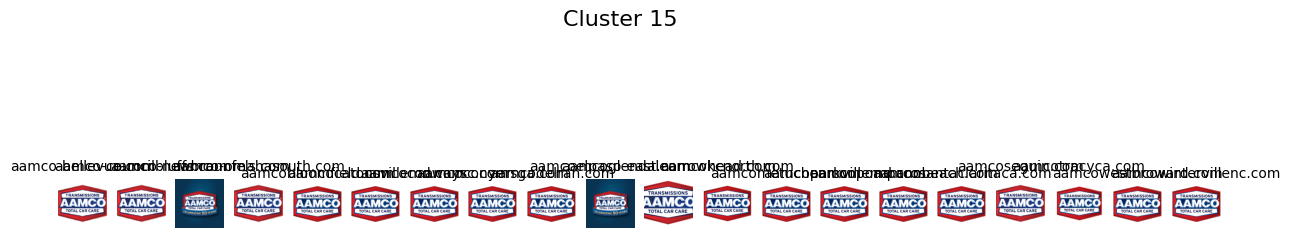

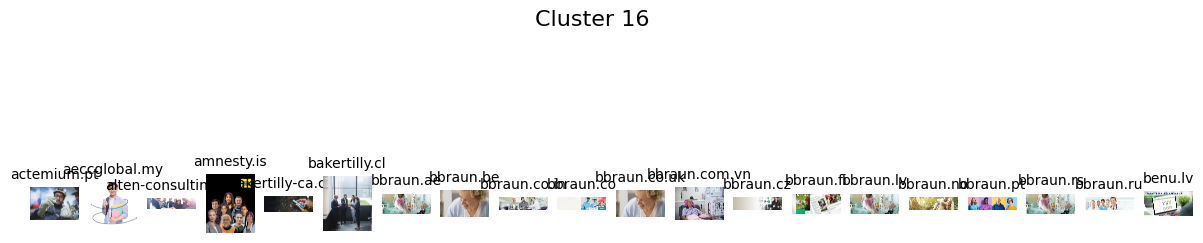

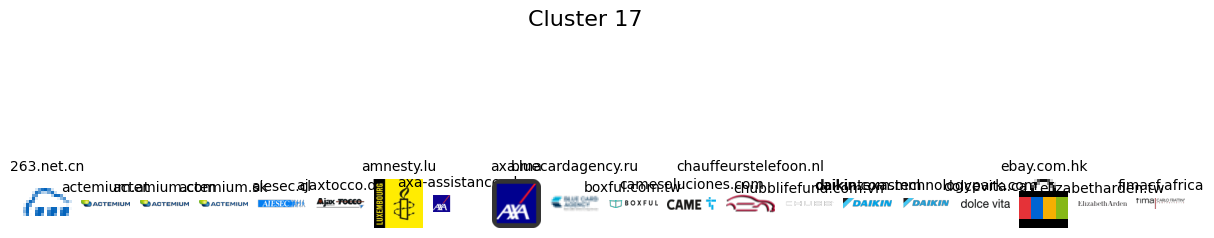

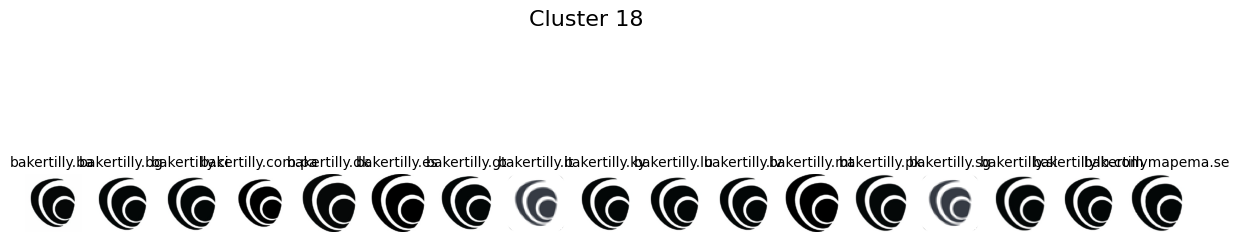

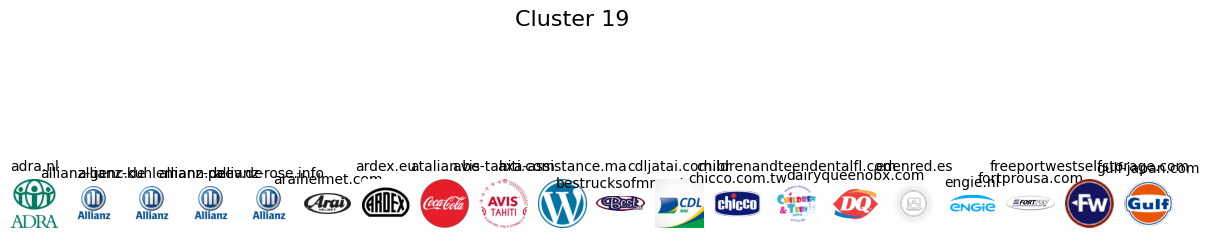

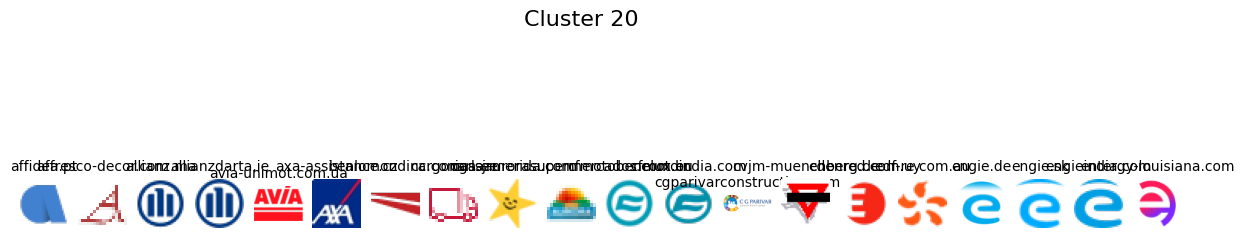

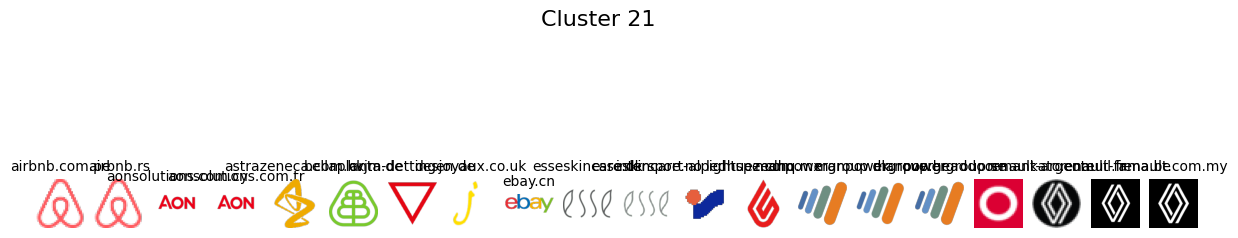

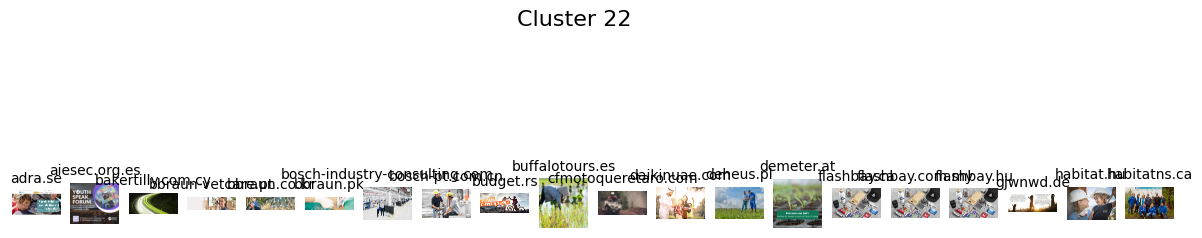

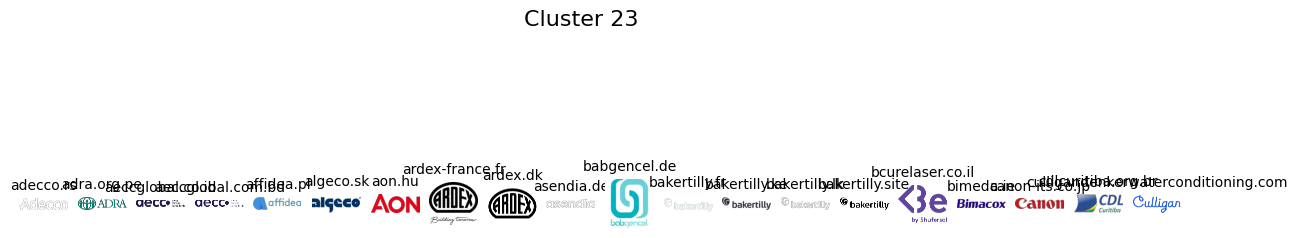

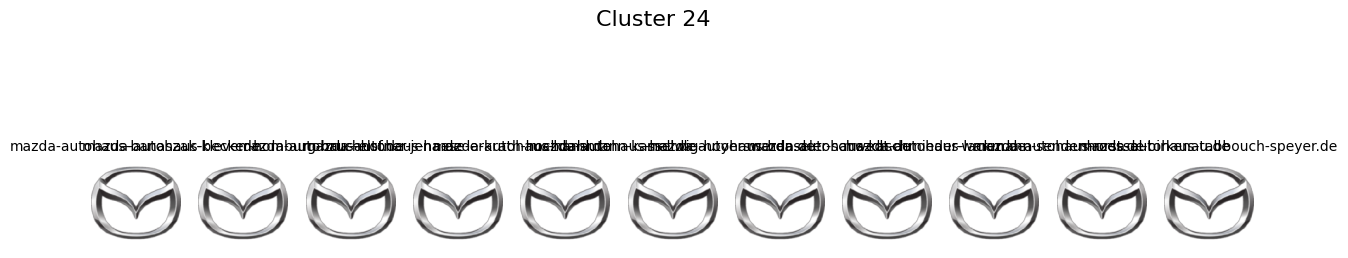

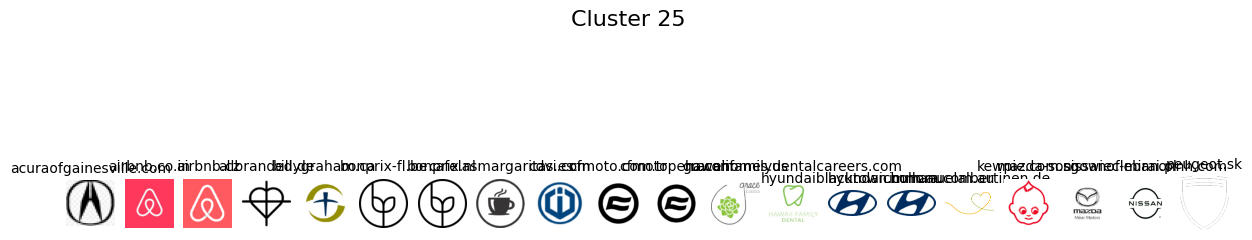

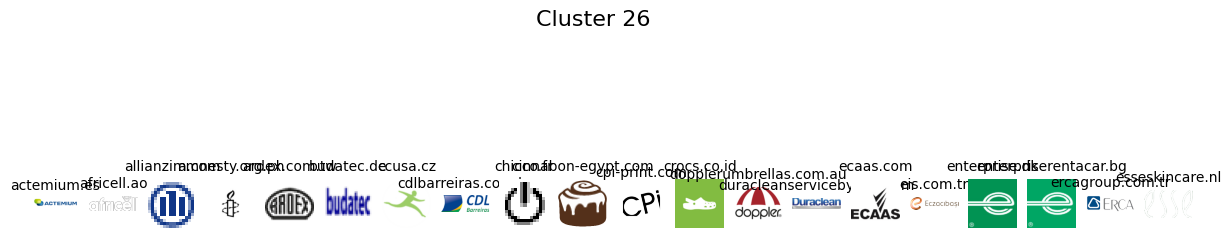

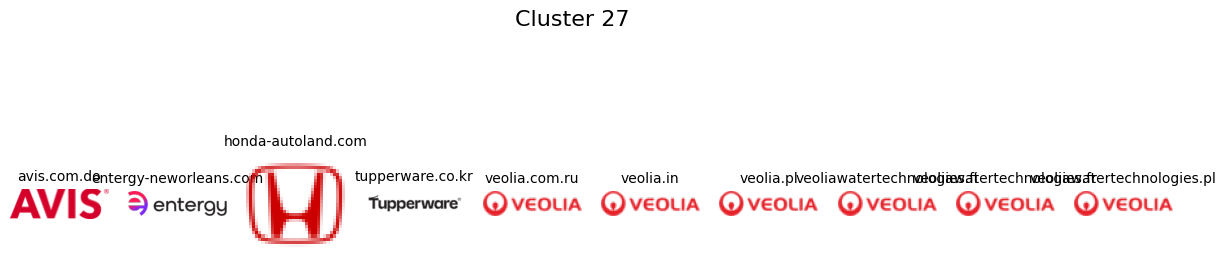

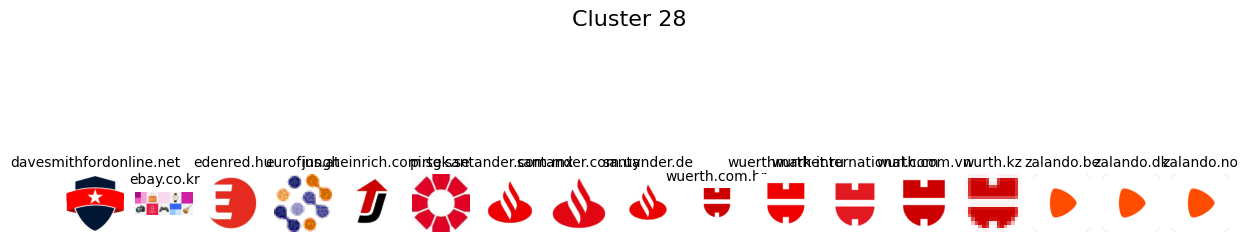

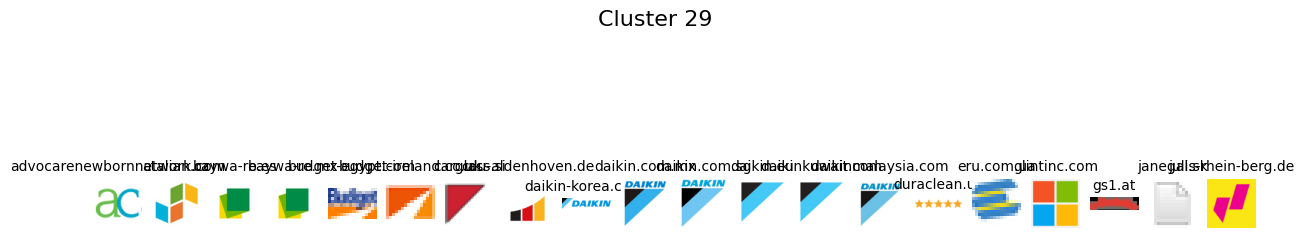

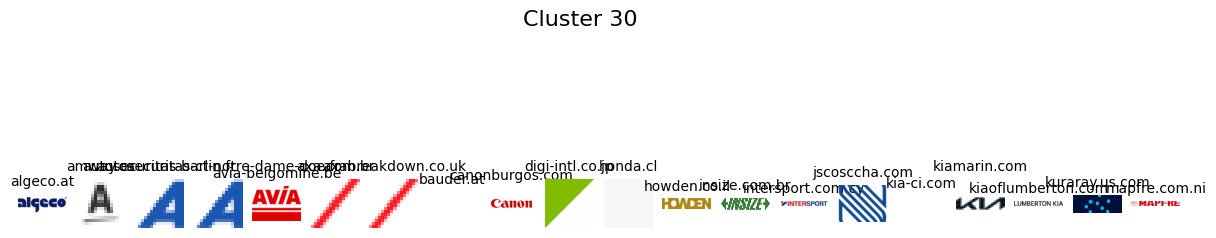

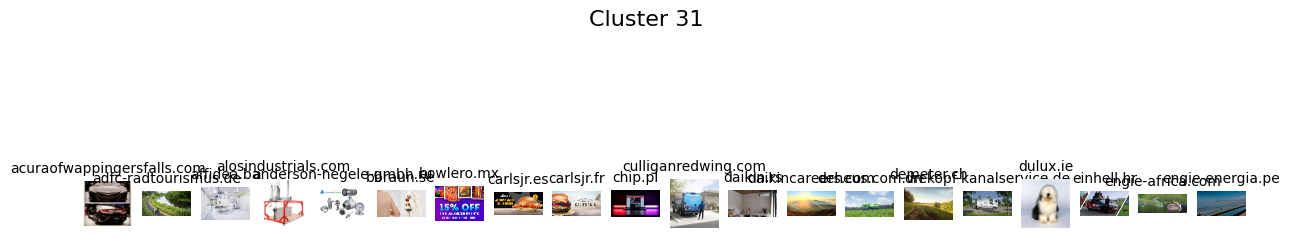

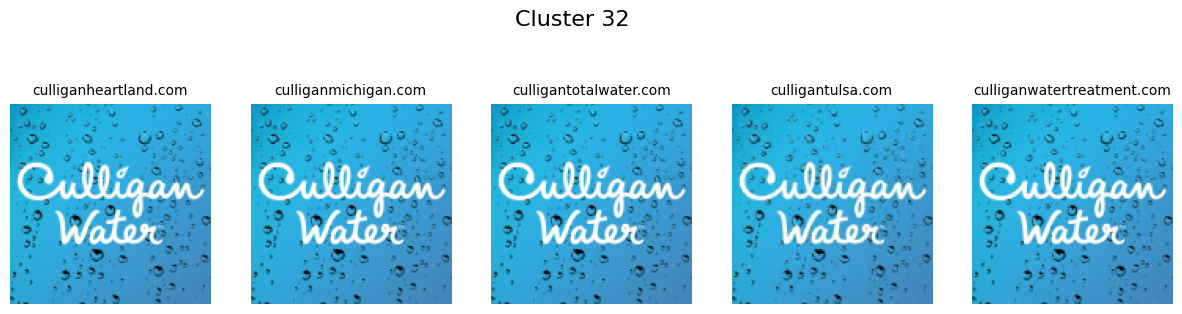

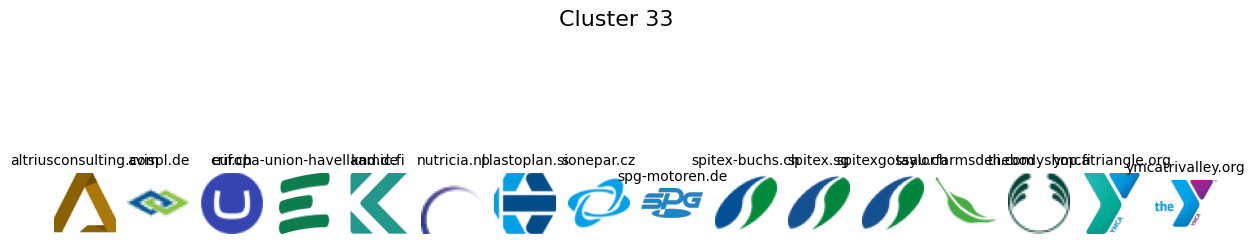

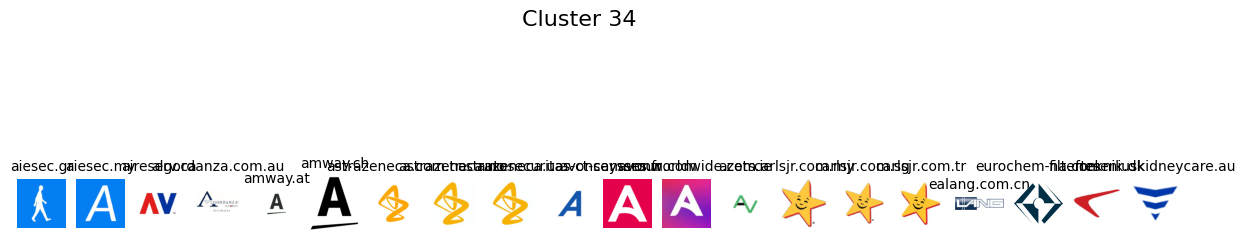

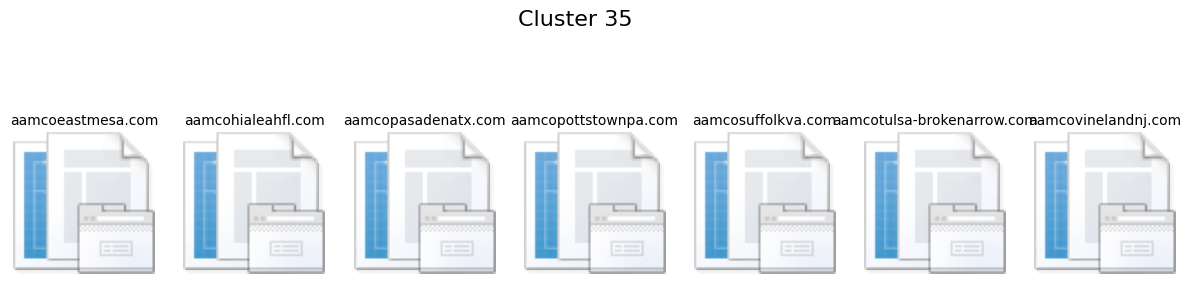

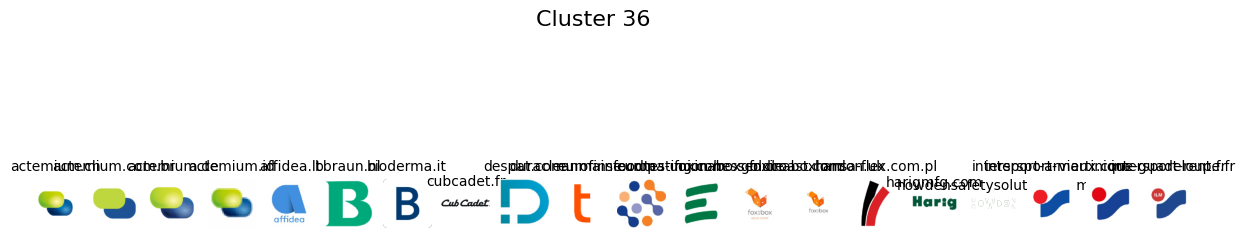

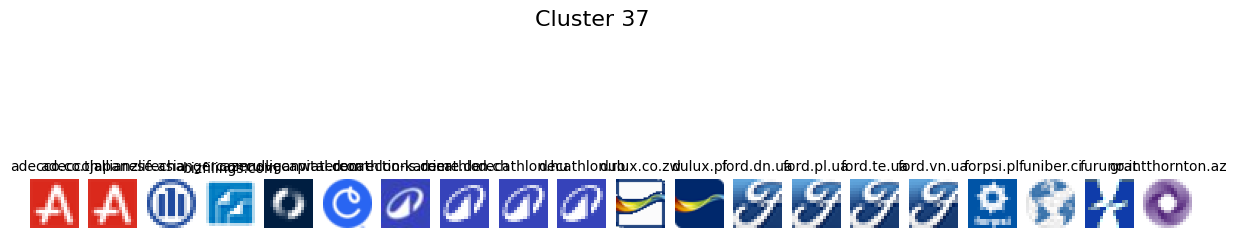

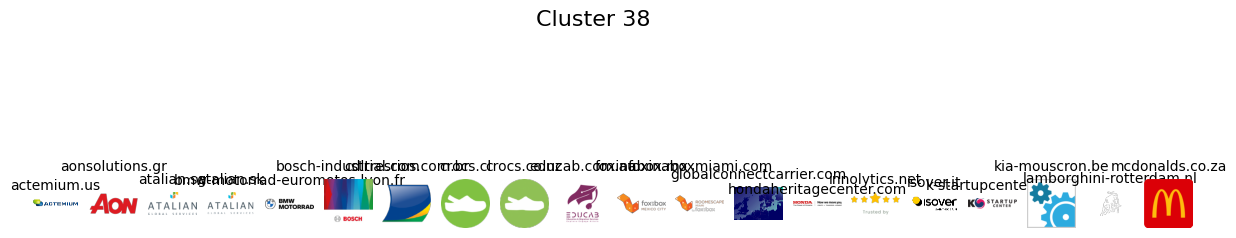

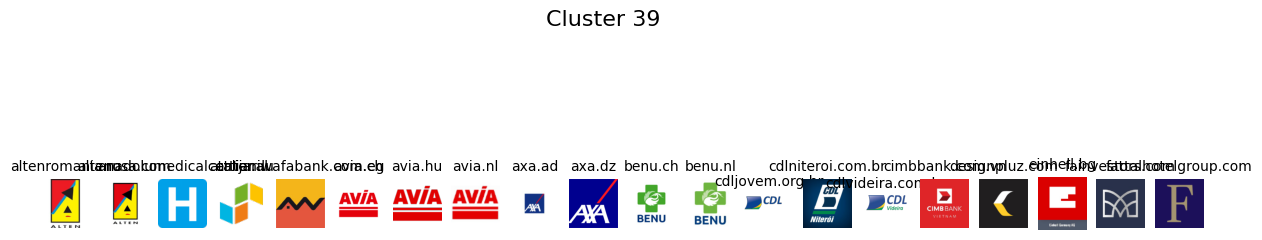

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import imagehash

# ---------------------------
# Step 1: Preprocess the Images
# ---------------------------

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """Load an image file, resize, and normalize it."""
    img = Image.open(img_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img)
    # MobileNetV2 expects values in a certain range after preprocessing.
    img_array = preprocess_input(img_array)
    return img_array

# Set your logos folder path:
# For direct upload (unzipped): logo_dir = "logos"
# For Google Drive mount: logo_dir = "/content/drive/My Drive/logos"
logo_dir = "logos"  # update this if needed

# Get a list of logo image paths.
image_files = [os.path.join(logo_dir, f) for f in os.listdir(logo_dir) if f.lower().endswith(".png")]

# Load and preprocess all images.
images = np.array([load_and_preprocess_image(fp) for fp in image_files])
print("Loaded and preprocessed", len(images), "images.")

# ---------------------------
# Step 2: Feature Extraction Using MobileNetV2
# ---------------------------

# Load MobileNetV2 without top layers (use global average pooling to get a flat vector).
base_model = MobileNetV2(weights="imagenet", include_top=False, pooling='avg', input_shape=(224,224,3))
# Extract features for all images.
features = base_model.predict(images, batch_size=64)
print("Extracted features shape:", features.shape)

# ---------------------------
# Step 3: Cluster the Logos
# ---------------------------

# Choose a number of clusters. You can experiment with this.
n_clusters = 40
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# ---------------------------
# Step 4: Visualize and Interpret the Clusters
# ---------------------------

# Optionally, reduce dimensions for visualization.
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

plt.figure(figsize=(10,8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title("Logo Clusters (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Cluster")
plt.show()

# ---------------------------
# Optional: Print Cluster Composition
# ---------------------------
# If you have a mapping from image files to domains, you can extract that info:
domains_list = [os.path.splitext(os.path.basename(fp))[0] for fp in image_files]

clusters = {}
for domain, label in zip(domains_list, cluster_labels):
    clusters.setdefault(label, []).append(domain)

for label, group in clusters.items():
    print(f"Cluster {label}: {group}")

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# unique clusters
unique_labels = np.unique(cluster_labels)

for label in unique_labels:
    # Get indices for the current cluster
    indices = np.where(cluster_labels == label)[0]
    num_images_to_show = min(20, len(indices))

    # Create a new figure for each cluster
    plt.figure(figsize=(15, 4))
    plt.suptitle(f"Cluster {label}", fontsize=16)

    for i in range(num_images_to_show):
        idx = indices[i]
        # Open the image file using PIL
        img = Image.open(image_files[idx])
        plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.splitext(os.path.basename(image_files[idx]))[0], fontsize=10)
    plt.show()


In [ ]:
import os
import re
import shutil
import numpy as np

# For image processing and model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity

# Define paths
input_folder = 'C:\Users\vgale\Desktop\Code\Logo_Recognition_ML\logos'  # adjust as needed
output_folder = 'C:\Users\vgale\Desktop\Code\Logo_Recognition_ML\output_folders'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# --- Step 1: Text-Based Grouping ---
def extract_company_token(filename):
    """
    Extract a simple token representing the company from the file name.
    This example extracts the first sequence of alphabets.
    Modify this function if you need a more advanced extraction.
    """
    name, _ = os.path.splitext(filename)
    # Remove common domain extensions
    name = re.sub(r'\.(com|ro|net|org)$', '', name, flags=re.IGNORECASE)
    # Extract the first sequence of alphabets (you might refine this)
    match = re.match(r'([A-Za-z]+)', name)
    return match.group(1).lower() if match else name.lower()

# Group the images based on extracted token
grouped_files = {}
for file in os.listdir(input_folder):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        token = extract_company_token(file)
        grouped_files.setdefault(token, []).append(file)

print("Text-based groups:")
for company, files in grouped_files.items():
    print(f"{company}: {len(files)} files")

# --- Step 2: (Bonus) Image-Based Similarity ---
# Load a pretrained model for feature extraction
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def get_feature_vector(img_path):
    """Load image, preprocess, and extract features using the pretrained model."""
    try:
        img = image.load_img(img_path, target_size=(224, 224))
    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        return None
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

# For each text-group with more than one image, perform clustering based on image similarity
refined_groups = {}  # to hold final grouping: keys will be compound names

for token, files in grouped_files.items():
    if len(files) == 1:
        # Single image, add directly
        refined_groups[f"{token}_group0"] = files
    else:
        # Extract features for all images in this group
        features = []
        valid_files = []
        for file in files:
            fvec = get_feature_vector(os.path.join(input_folder, file))
            if fvec is not None:
                features.append(fvec)
                valid_files.append(file)
        if len(features) == 0:
            continue
        features = np.array(features)

        # Cluster the images using DBSCAN with cosine distance.
        # You might need to adjust eps based on your data
        clustering = DBSCAN(eps=0.2, metric='cosine').fit(features)
        labels = clustering.labels_

        # Organize files into sub-groups based on clustering labels
        for file, label in zip(valid_files, labels):
            group_key = f"{token}_group{label}"
            refined_groups.setdefault(group_key, []).append(file)

print("\nRefined groups (after image similarity clustering):")
for group_key, files in refined_groups.items():
    print(f"{group_key}: {len(files)} files")

# --- Step 3: Create Folders and Move Files ---
for group_key, files in refined_groups.items():
    # Create a folder for the group
    group_path = os.path.join(output_folder, group_key)
    if not os.path.exists(group_path):
        os.makedirs(group_path)
    # Move the files into the group folder
    for file in files:
        src = os.path.join(input_folder, file)
        dst = os.path.join(group_path, file)
        try:
            shutil.move(src, dst)
        except Exception as e:
            print(f"Error moving {file}: {e}")

print("\nFiles have been organized into their respective company folders.")
